In [1]:
import pickle
from venn import venn
import matplotlib.pyplot as plt
import pandas as pd
import OAI_Utilities as utils

from upsetplot import UpSet, from_contents
from IPython.display import display, HTML

In [2]:
moaks_df = pickle.load(open('/Users/franceskoback/Library/Mobile Documents/com~apple~CloudDocs/Documents/Spring 2023/Research-Local/CAIRO_Lab/pkl/kmri_sq_moaks_bicl_values.pkl', 'rb'))
# ACL tears
#print(moaks_df['MACLTR'].value_counts())
# How many unique patients with ACL partial and complete tear
print(len(moaks_df[moaks_df['MACLTR'] == '1: Partial tear'].index.get_level_values('ID').unique()))
print(len(moaks_df[moaks_df['MACLTR'] == '2: Complete tear'].index.get_level_values('ID').unique()))
# ACL repair
#moaks_df['MACLRP'].value_counts()
#print(moaks_df['MACLRP'].value_counts())
print(len(moaks_df[moaks_df['MACLRP'] == '1: Yes'].index.get_level_values('ID').unique()))

101
61
7


Take those unique lists and convert them to sets().  Then get the set of unique IDs for the TKA cohort and you can get the intersection ( & ) of the two sets to see how many got a TKA AND had partial or complete tear.  Step one, how many actual cases are there?

In [3]:
ACL_Repair_Set=set(moaks_df[moaks_df['MACLRP'] == '1: Yes'].index.get_level_values('ID').unique().values)
ACL_PartialTear_Set=set(moaks_df[moaks_df['MACLTR'] == '1: Partial tear'].index.get_level_values('ID').unique().values)
ACL_Tear_Set=set(moaks_df[moaks_df['MACLTR'] == '2: Complete tear'].index.get_level_values('ID').unique().values)

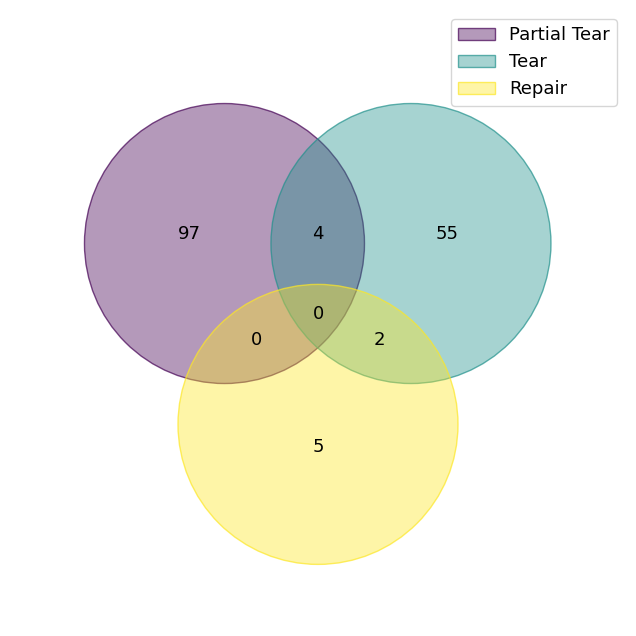

In [4]:
patients = {
    #'All': set(allclinical_df.index.get_level_values('ID')),
    'Partial Tear': ACL_PartialTear_Set,
    'Tear': ACL_Tear_Set,
    'Repair': ACL_Repair_Set,
}
plot = venn(patients)
#plot.get_figure().savefig("TKA_venn.svg")

In [5]:
tka_ids_dict = pickle.load(open('/Users/franceskoback/Library/Mobile Documents/com~apple~CloudDocs/Documents/Spring 2023/Research-Local/CAIRO_Lab/pkl/TKA_ids.pkl', 'rb'))
tka_ids = tka_ids_dict['TKA']
right_tka_ids = tka_ids_dict['TKA_Right']
left_tka_ids = tka_ids_dict['TKA_Left']
bilat_tka_ids = tka_ids_dict['TKA_Bilat']
lr_tka_ids = tka_ids_dict['TKA_LR']
tka_visit_ids = tka_ids_dict['TKA_Visit']

tka_df = pickle.load(open('/Users/franceskoback/Library/Mobile Documents/com~apple~CloudDocs/Documents/Spring 2023/Research-Local/CAIRO_Lab/pkl/TKA_PROs_df.pkl', 'rb'))

In [6]:
tka_df['KOOSADLR'] = (100 - ((tka_df['WOMADLR'] / 68) * 100))
tka_df['KOOSADLL'] = (100 - ((tka_df['WOMADLL'] / 68) * 100))

In [7]:
r_tka_df = tka_df.loc[tka_df.index.get_level_values(0).isin(right_tka_ids)]
l_tka_df = tka_df.loc[tka_df.index.get_level_values(0).isin(left_tka_ids)]

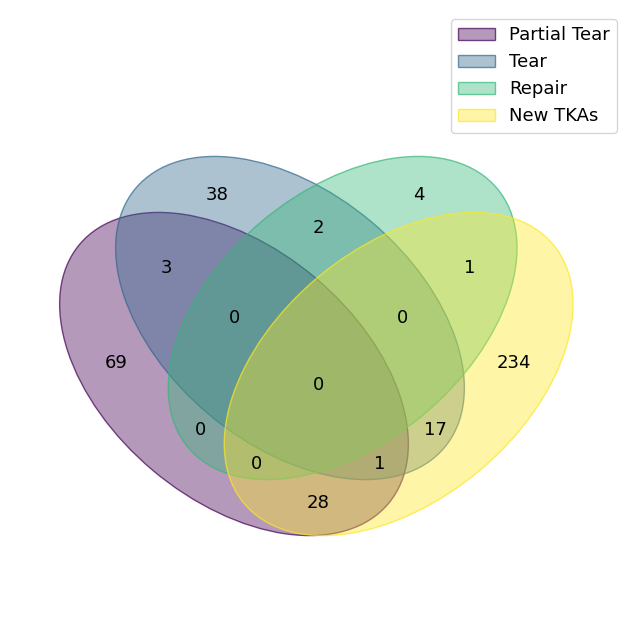

In [8]:
patients = {
    #'All': set(allclinical_df.index.get_level_values('ID')),
    'Partial Tear': ACL_PartialTear_Set,
    'Tear': ACL_Tear_Set,
    'Repair': ACL_Repair_Set,
    'New TKAs': tka_ids
}
plot = venn(patients)
#plot.get_figure().savefig("TKA_venn.svg")

In [9]:
tka_ids = tka_ids_dict['TKA']

In [10]:
#ACL_PartialTear_Set
ACL_issue_set= (ACL_PartialTear_Set | ACL_Tear_Set | ACL_Repair_Set ) & tka_ids
No_ACL_issue_set= tka_ids - ACL_issue_set

In [11]:
len(ACL_issue_set) #47
len(No_ACL_issue_set) #234 

234

## Function Definitions

In [12]:
# TODO: 
# - create_dfs_graphs() takes var_dict but this can be either a list of vars to graph together OR left vs right data, shouldn't be both
#   Figure out new form that cleans this up

# Create the statistical DFs for each OAI variable in var_dict and plot the means of them to screen 
# - if var_dict and lr_subsets are tuples, then they are presumed to be left/right subsets for TKA patients
#   for side specific metrics only collect the PRO for TKA patients who had that knee operated on
def create_dfs_graphs(var_dict, graph_title, title1, title2, ylabel, graph_filename, lr_subsets=None, ylim=None):
    if not lr_subsets:
        return create_all_tka_dfs_graphs(var_dict, graph_title, ylabel, graph_filename, ylim)
    else:
        tka_sides_dict = dict()
        for idx, side in {0: str(title1), 1: str(title2)}.items():
            tka_sides_dict[side] = create_all_tka_dfs_graphs(var_dict[idx], graph_title  + side, ylabel, graph_filename + ' ' + str.lower(side), ylim, lr_subsets[idx])
        
        return pd.concat(tka_sides_dict ,names=['Inflammatory Phenotype'])

# Create the statistical DFs for each OAI variable in var_dict and plot the means of them to screen
# Returns a tuple of dataframes (all, TKA)
def create_all_tka_dfs_graphs(var_dict, graph_title, ylabel, graph_filename, ylim, subset=None):    
    # TKA
    tmp_df = tka_df
    if subset:
        tmp_df = tka_df.loc[tka_df.index.get_level_values(0).isin(subset)]
    tka_stats_df = get_stats_df(tmp_df, var_dict)
    tka_stats_df = tka_stats_df.reindex(index = [(m, v) for m in list(tka_stats_df.index.levels[0]) for v in utils.prior_post_visits ]).dropna()
    axes = tka_stats_df.unstack(level=0)['Mean'].reindex(index = utils.prior_post_visits).plot(title=graph_title, ylabel=ylabel, xlabel='Visit')
    if ylim:
        axes.set_ylim(ylim)
    plt.show()    
    return tka_stats_df


# Given a dict of OAI variable names (OAI name: pretty print name), return a dataframe with
# the Min, Max, Mean, StdDev, Count for each visit
# A separate row index is made for each OAI metric labelled with the pretty print name
def get_stats_df(df, cols):   
    stats_dict = dict()
    for k, v in cols.items():
        tmp_df = pd.DataFrame()
        tmp_df['Min'] = df[k].groupby('Visit').min()
        tmp_df['Max'] = df[k].groupby('Visit').max()        
        tmp_df['Mean'] = df[k].groupby('Visit').mean()
        tmp_df['StdDev'] = df[k].groupby('Visit').std()
        tmp_df['Count'] = df[k].groupby('Visit').count()        
        tmp_df = tmp_df.dropna()
        stats_dict[v] = tmp_df
    return pd.concat(stats_dict, names=['Metric'])


In [13]:
koos_ACL_issue_cols = {'KOOSKPR': 'KOOS Pain Right',
             'KOOSKPL': 'KOOS Pain Left',
             'KOOSYML': 'KOOS Symptoms Left',
             'KOOSYMR': 'KOOS Symptoms Right',
             'KOOSADLL': 'KOOS AD Left',
             'KOOSADLR': 'KOOS ADL Right'
             }
koos_no_ACL_issue_cols = {'KOOSKPR': 'KOOS Pain Right',
             'KOOSKPL': 'KOOS Pain Left',
             'KOOSYML': 'KOOS Symptoms Left',
             'KOOSYMR': 'KOOS Symptoms Right',
             'KOOSADLL': 'KOOS AD Left',
             'KOOSADLR': 'KOOS ADL Right'
             }

koos_lr_subscale_dict = {'Pain': ['KOOSKPR', 'KOOSKPL'],
               'Symptoms': ['KOOSYMR', 'KOOSYML'],
                'ADL': ['KOOSADLR', 'KOOSADLL']
              }
# koos_r_cols = {'KOOSKPR': 'KOOS Pain'
#              }
# koos_l_cols = {'KOOSKPL': 'KOOS Pain'
#              }

# koos_lr_subscale_dict = {'Pain': ['KOOSKPR', 'KOOSKPL'],
#                'Symptoms': ['KOOSYMR', 'KOOSYML'],
#                 'ADL': ['KOOSADLR', 'KOOSADLL']
#               }

In [14]:
ACL_or_no_IDS= (ACL_issue_set,No_ACL_issue_set)

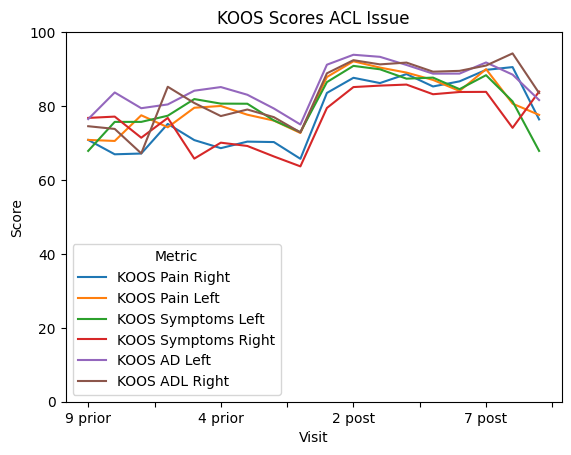

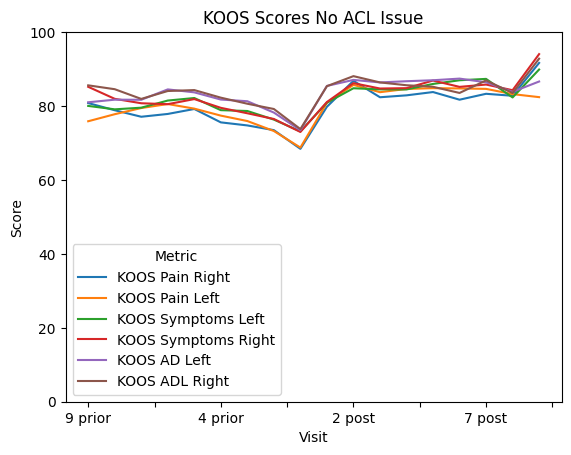

In [15]:
tka_koos_tka_df = create_dfs_graphs((koos_ACL_issue_cols,koos_no_ACL_issue_cols), 'KOOS Scores ', 'ACL Issue', 'No ACL Issue', 'Score', 'KOOS_', ylim=[0, 100], lr_subsets=ACL_or_no_IDS)


In [16]:
koos_ACL_issue_cols = {'KOOSKPR': 'KOOS Pain Right',
             'KOOSKPL': 'KOOS Pain Left',
             }
koos_no_ACL_issue_cols = {'KOOSKPR': 'KOOS Pain Right',
             'KOOSKPL': 'KOOS Pain Left',
             }

In [17]:
# var_dict[0]==koos_ACL_issue_cols
condition_ids=tka_ids

In [18]:
title1= 'ACL Issue'
title2= 'No ACL Issue'
graph_title= 'KOOS Scores '
graph_filename='KOOS_'
ylim=[0, 100]
lr_subsets=ACL_or_no_IDS
tka_sides_dict = dict()




def create_all_tka_dfs_graphs(var_dict, graph_title, ylabel, graph_filename, ylim, subset=None):    
    # TKA
    tmp_df = tka_df
    if subset:
        tmp_df = tka_df.loc[tka_df.index.get_level_values(0).isin(subset)]
    tka_stats_df = get_stats_df(tmp_df, var_dict)
    tka_stats_df = tka_stats_df.reindex(index = [(m, v) for m in list(tka_stats_df.index.levels[0]) for v in utils.prior_post_visits ]).dropna()
    axes = tka_stats_df.unstack(level=0)['Mean'].reindex(index = utils.prior_post_visits).plot(title=graph_title, ylabel=ylabel, xlabel='Visit')
    if ylim:
        axes.set_ylim(ylim)
    plt.show()    
    return tka_stats_df


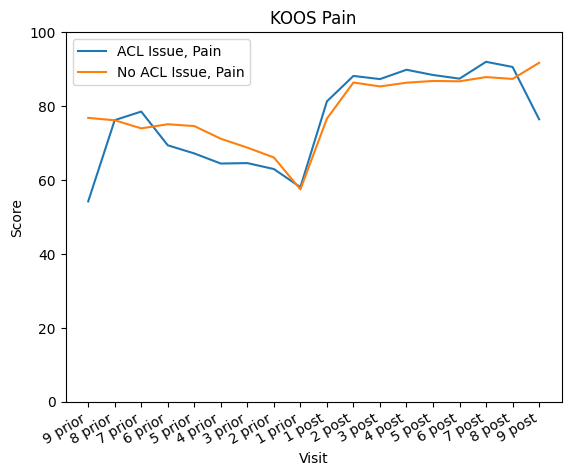

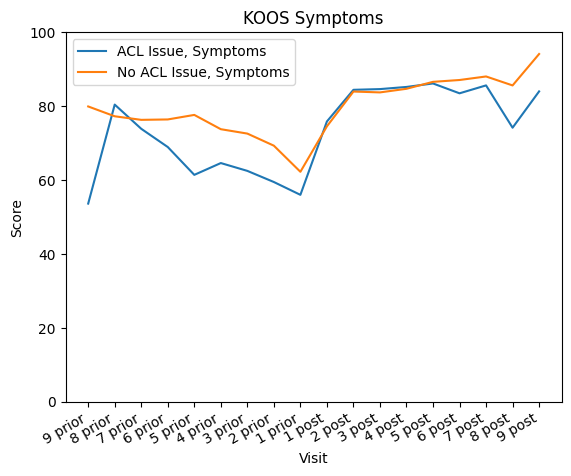

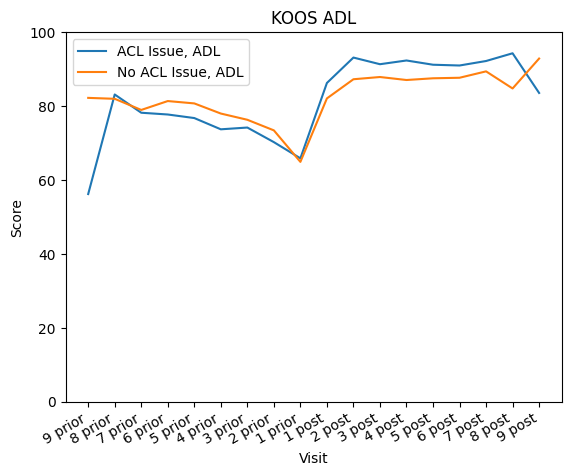

In [19]:
title1= 'ACL Issue'
title2= 'No ACL Issue'
graph_title= 'KOOS Pain Scores '
graph_filename='KOOS_'
ylim=[0, 100]

lr_subsets=ACL_or_no_IDS
tka_sides_dict = dict()
ylabel="Score"
ACL_or_no_IDS= (ACL_issue_set,No_ACL_issue_set) 
koos_ACL_issue_cols = {'KOOSKPR': 'KOOS Pain Right',
             'KOOSKPL': 'KOOS Pain Left',
             }

condition_IDS=ACL_or_no_IDS

def graph_conditions(koos_ACL_issue_cols,condition_IDS,title_list):
    j=0
    DF_list = list()
    tka_stats_list=list()
    dataframe_list=list()
    while j < len(condition_IDS): 
        DF_list.append(tka_df.loc[tka_df.index.get_level_values(0).isin(condition_IDS[j])])
        tka_stats_list.append(get_stats_df(DF_list[j], koos_ACL_issue_cols)) 
        tka_stats_list[j] = tka_stats_list[j].reindex(index = [(m, v) for m in list(tka_stats_list[j].index.levels[0]) for v in utils.prior_post_visits ]).dropna() 
        dataframe_list.append(tka_stats_list[j].unstack(level=0)['Mean'].reindex(index = utils.prior_post_visits))
        j+=1

    for i in koos_ACL_issue_cols:
        j=0
        fig, ax = plt.subplots()
        while j < len(dataframe_list):
            dataframe_temp=dataframe_list[j]
            ax.plot(dataframe_temp[str(koos_ACL_issue_cols[str(i)])],label=title_list[j]+ ", " + str(koos_ACL_issue_cols[str(i)]))
            j+=1
        ax.set_autoscale_on(True)
        ax.set_xlabel("Visit")
        ax.legend()
        ax.set_ylabel(ylabel)
        plt.title(str(koos_ACL_issue_cols[str(i)]))
        plt.ylim((0,100))
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    return 



def graph_conditions_both_knees(lr_var_dict,condition_IDS,title_list):
    j=0
    DF_list = list()
    tka_stats_list=list()
    dataframe_list=list()
    both_dict = dict()
    for metric_name, lr_var_names in lr_var_dict.items():
            both_df = pd.concat([r_tka_df[lr_var_names[0]], l_tka_df[lr_var_names[1]]])
            both_dict[metric_name] = both_df
    both_df = pd.concat(both_dict, axis=1)
    

    while j < len(condition_IDS): 
        DF_list.append(both_df.loc[both_df.index.get_level_values(0).isin(condition_IDS[j])])
        tka_stats_list.append(get_stats_df(DF_list[j],{m:m for m in lr_var_dict.keys()} )) 
        tka_stats_list[j] = tka_stats_list[j].reindex(index = [(m, v) for m in list(tka_stats_list[j].index.levels[0]) for v in utils.prior_post_visits ]).dropna() 
        #print(tka_stats_list[j])
        dataframe_list.append(tka_stats_list[j].unstack(level=0)['Mean'].reindex(index = utils.prior_post_visits))
        j+=1

    j=0
    
    col_list=dataframe_list[0]
    for col in col_list:
        fig, ax = plt.subplots()
        j=0
        while j < len(dataframe_list):
            dataframe_temp=dataframe_list[j]
            ax.plot(dataframe_temp[col],label=title_list[j]+ ", "+col)
            ax.set_autoscale_on(True)
            ax.set_xlabel("Visit")
            ax.legend()
            ax.set_ylabel(ylabel)
            j+=1
            plt.title("KOOS "+str(col))
            plt.ylim((0,100))
            plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')





    

koos_lr_subscale_dict = {'Pain': ['KOOSKPR', 'KOOSKPL'],
               'Symptoms': ['KOOSYMR', 'KOOSYML'],
                'ADL': ['KOOSADLR', 'KOOSADLL']
              }
title1= 'ACL Issue'
title2= 'No ACL Issue'
title_list=[title1,title2]
koos_ADL_cols = {'KOOSADLR': 'KOOS ADL Right',
                       'KOOSADLL': 'KOOS ADL Left'
             }

koos_pain__cols = {'KOOSKPR': 'KOOS Pain Right',
             'KOOSKPL': 'KOOS Pain Left',
             }
koos_symptoms_cols = {'KOOSYMR': 'KOOS Symptoms Right',
             'KOOSYML': 'KOOS Symptoms Left',
             }


#graph_conditions(koos_ADL_cols,ACL_or_no_IDS,title_list)
graph_conditions_both_knees(koos_lr_subscale_dict,ACL_or_no_IDS,title_list)

In [20]:
j=0
DF_list = list()
tka_stats_list_1=list()
tka_stats_list_2=list()
dataframe_list=list()
both_dict = dict()
lr_var_dict=koos_lr_subscale_dict
for metric_name, lr_var_names in lr_var_dict.items():
    both_df = pd.concat([r_tka_df[lr_var_names[0]], l_tka_df[lr_var_names[1]]])
    both_dict[metric_name] = both_df
both_df = pd.concat(both_dict, axis=1)
#print(both_df)

while j < len(condition_IDS): 
    DF_list.append(tka_df.loc[tka_df.index.get_level_values(0).isin(condition_IDS[j])])
    tka_stats_list_1.append(get_stats_df(DF_list[j], koos_ACL_issue_cols)) 
    tka_stats_list_2.append(get_stats_df(both_df, {m:m for m in lr_var_dict.keys()}))
    j+=1


print(tka_stats_list_1)
print(tka_stats_list_2)
    

[                               Min         Max       Mean     StdDev  Count
Metric          Visit                                                      
KOOS Pain Right 1 post   37.500000  100.000000  83.547577  16.684671     47
                1 prior  25.000000  100.000000  65.723106  21.813291     45
                2 post   32.142857  100.000000  87.641891  15.732771     43
                2 prior  30.555555  100.000000  70.254631  19.531083     45
                3 post   44.444443  100.000000  86.216843  14.392621     38
                3 prior  33.333332  100.000000  70.373260  17.993879     40
                4 post   46.875000  100.000000  88.651314  13.869897     38
                4 prior  16.666666  100.000000  68.605324  23.000213     24
                5 post   47.222221  100.000000  85.297035  15.062307     34
                5 prior  43.750000  100.000000  70.783730  18.687007     14
                6 post   34.375000  100.000000  86.681549  15.966690     28
           

In [21]:
condition_ids=set(tka_ids)
DF_list = list()
DF_list.append(both_df.loc[both_df.index.get_level_values(0).isin(condition_ids)])
#DF_list.append(tka_df.loc[tka_df.index.get_level_values(0).isin(condition_ids)])
#tka_stats_list_1.append(get_stats_df(DF_list[0], koos_ACL_issue_cols)) 
tka_stats_list_2.append(get_stats_df(both_df, {m:m for m in lr_var_dict.keys()}))

In [22]:
both_df

Pain    Symptoms         ADL
ID      Visit                                      
9557454 1 prior   68.750000   89.285713   75.000000
        1 post    63.888889   67.857140   88.235291
        2 post   100.000000  100.000000  100.000000
        3 post   100.000000  100.000000  100.000000
        4 post   100.000000  100.000000  100.000000
...                     ...         ...         ...
9802615 4 prior   46.875000   53.571430   68.333336
        3 prior   47.222221   57.142857   70.312500
        2 prior   53.125000   53.571430   69.117645
        1 prior   65.625000   64.285713   73.529411
        1 post    94.444443   96.428574  100.000000

[2962 rows x 3 columns]

In [23]:
var_dict=lr_var_dict

In [25]:
my_list=[]
import numpy as np
for idx, data in list.groupby(level=0):
    if (idx, '2 post') in data.index and (idx, '1 prior') in data.index:
        result = data.loc[(idx, '2 post')] - data.loc[(idx, '1 prior')]
        if type(result) == np.float32:
            my_list.append(result)

/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/423675962.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (idx, '2 post') in data.index and (idx, '1 prior') in data.index:
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/423675962.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = data.loc[(idx, '2 post')] - data.loc[(idx, '1 prior')]
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/423675962.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (idx, '2 post') in data.index and (idx, '1 prior') in data.index:
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/423675962.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = data.loc[(idx, '2 post')] - data.loc[(idx, '1 prior')]
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/423675962.py:4: PerformanceWarning: indexing past

In [104]:
AutoML_dataframe


,id,pain,inflam,cm,subc,atroph,hypertrop
9005132,9005132,31.25,NaN,NaN,NaN,NaN,NaN
9011918,9011918,22.222221,NaN,NaN,NaN,NaN,NaN
9014883,9014883,11.111115,NaN,NaN,NaN,NaN,NaN
9015363,9015363,55.555557,NaN,NaN,NaN,NaN,NaN
9027422,9027422,19.44445,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
9976720,9976720,44.444443,NaN,NaN,NaN,NaN,NaN
9988891,9988891,44.444443,NaN,NaN,NaN,NaN,NaN
9991313,9991313,33.333336,NaN,NaN,NaN,NaN,NaN
9992318,9992318,25.0,NaN,NaN,NaN,NaN,NaN


In [103]:
AutoML_dataframe = pd.DataFrame(columns=['id','pain', 'inflam', 'cm', 'subc', 'atroph', 'hypertrop'])
data_list = DF_list[0]
my_list = []

for idx, data in data_list.groupby(level=0):
    if (idx, '2 post') in data.index and (idx, '1 prior') in data.index:
        two_post = data.loc[(idx, '2 post')]["Pain"]
        one_prior = data.loc[(idx, '1 prior')]["Pain"]
        result = two_post - one_prior
        if isinstance(result, np.float32):
            my_list.append(result)
            AutoML_dataframe.loc[idx, 'id'] = idx
            AutoML_dataframe.loc[idx, 'pain'] = result

/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/1954696543.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (idx, '2 post') in data.index and (idx, '1 prior') in data.index:
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/1954696543.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  two_post = data.loc[(idx, '2 post')]["Pain"]
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/1954696543.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  one_prior = data.loc[(idx, '1 prior')]["Pain"]
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/1954696543.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (idx, '2 post') in data.index and (idx, '1 prior') in data.index:
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_51456/1954696543.py:7: PerformanceWarning: indexing past lexsort depth may impact perfo

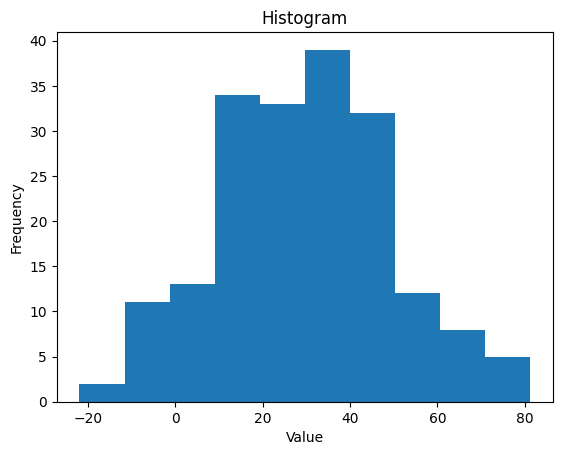

In [29]:
plt.hist(my_list)
# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the histogram
plt.show() 

In [152]:
data

1  A    10
   B    20
2  A    30
   B    40
dtype: int64

In [43]:
stats_df=get_stats_df(DF_list[1], koos_ACL_issue_cols)
stats_df
stats_df.to_csv('stats_df.csv')
#DF_list

IndexError: list index out of range

In [74]:
print(tka_stats_list_2)

[                        Min    Max       Mean     StdDev  Count
Metric   Visit                                                 
Pain     1 post   12.500000  100.0  77.356148  19.906330    318
         1 prior  12.500000  100.0  57.514473  18.609665    303
         2 post   27.777779  100.0  86.674232  15.841547    261
         2 prior  11.111111  100.0  65.516808  18.857879    298
         3 post   40.625000  100.0  85.670532  16.033071    212
         3 prior   0.000000  100.0  68.011040  17.822629    273
         4 post   33.333332  100.0  87.156815  15.245531    172
         4 prior   5.555555  100.0  70.304451  19.240243    231
         5 post   19.444445  100.0  87.233383  15.973880    128
         5 prior   0.000000  100.0  73.933914  18.610293    193
         6 post   44.444443  100.0  86.915024  15.153772     87
         6 prior   8.333333  100.0  74.770081  19.448896    148
         7 post   36.111111  100.0  89.317131  14.221156     60
         7 prior   9.375000  100.0  74.

In [71]:
# Create an empty dataframe
df_subtracted = pd.DataFrame(columns=['SubtractionResult'])
stats_df=get_stats_df(DF_list[1], koos_ACL_issue_cols)
print(stats_df.axes)
# print(len(stats_df))
#stats_df.loc(('KOOS Pain Right',  '1 post'))
#print(stats_df)
# Loop through the rows with a step size of 2
# for i in range(0, len(stats_df), 2):
#      value1 = stats_df.loc[i, 'Mean']
#      print(value1)
    # value2 = stats_df.loc[i+1, 'Mean']
    # result = value2 - value1
    # df_subtracted = df_subtracted.append({'SubtractionResult': result}, ignore_index=True)

# Print the resulting dataframe
#print(df_subtracted)

[MultiIndex([('KOOS Pain Right',  '1 post'),
            ('KOOS Pain Right', '1 prior'),
            ('KOOS Pain Right',  '2 post'),
            ('KOOS Pain Right', '2 prior'),
            ('KOOS Pain Right',  '3 post'),
            ('KOOS Pain Right', '3 prior'),
            ('KOOS Pain Right',  '4 post'),
            ('KOOS Pain Right', '4 prior'),
            ('KOOS Pain Right',  '5 post'),
            ('KOOS Pain Right', '5 prior'),
            ('KOOS Pain Right',  '6 post'),
            ('KOOS Pain Right', '6 prior'),
            ('KOOS Pain Right',  '7 post'),
            ('KOOS Pain Right', '7 prior'),
            ('KOOS Pain Right',  '8 post'),
            ('KOOS Pain Right', '8 prior'),
            ('KOOS Pain Right',  '9 post'),
            ('KOOS Pain Right', '9 prior'),
            ( 'KOOS Pain Left',  '1 post'),
            ( 'KOOS Pain Left', '1 prior'),
            ( 'KOOS Pain Left',  '2 post'),
            ( 'KOOS Pain Left', '2 prior'),
            ( 'KOOS Pain Left',

In [34]:
# Create a sample dataframe
df = pd.DataFrame({'Value': [5, 10, 15, 20, 25, 30]})

# Create an empty dataframe
df_subtracted = pd.DataFrame(columns=['SubtractionResult'])

# Loop through the rows with a step size of 2
for i in range(0, len(df), 2):
    value1 = df.loc[i, 'Value']
    value2 = df.loc[i+1, 'Value']
    result = value1 - value2
    df_subtracted = df_subtracted.append({'SubtractionResult': result}, ignore_index=True)

# Print the resulting dataframe
print(df)
print(df_subtracted)

   Value
0      5
1     10
2     15
3     20
4     25
5     30
  SubtractionResult
0                -5
1                -5
2                -5


/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_98054/1253734501.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_subtracted = df_subtracted.append({'SubtractionResult': result}, ignore_index=True)
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_98054/1253734501.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_subtracted = df_subtracted.append({'SubtractionResult': result}, ignore_index=True)
/var/folders/t1/qbsdgjt54yj22kl83jmg040c0000gn/T/ipykernel_98054/1253734501.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_subtracted = df_subtracted.append({'SubtractionResult': result}, ignore_index=True)


In [476]:
tka_df.loc[tka_df.index.get_level_values(0).isin(ACL_or_no_IDS[0])]

KOOSKPR    KOOSKPL    KOOSYMR    KOOSYML    KOOSFSR  \
ID      Visit                                                            
9732751 1 prior  58.333332  75.000000  39.285713  75.000000        NaN   
        1 post   77.777779  83.333336  78.571426  92.857140        NaN   
        2 post   77.777779  75.000000  67.857140  78.571426        NaN   
        3 post   81.250000  62.500000  67.857140  67.857140        NaN   
        4 post   69.444443  55.555557  82.142860  67.857140        NaN   
...                    ...        ...        ...        ...        ...   
9298541 4 prior  50.000000  52.777779  53.571430  64.285713  10.000000   
        3 prior  33.333332  55.555557  39.285713  67.857140   5.000000   
        2 prior  61.111111  27.777779  64.285713  39.285713  10.000000   
        1 prior  52.777779  21.875000  42.857143  25.000000        NaN   
        1 post   72.222221  69.444443  89.285713  67.857140  41.666668   

                 KOOSQOL    WOMADLR    WOMADLL   KOOSADLR   KOOSADLL  
ID      Visit                                                         
9732751 1 prior    43.75  23.000000  18.000000  66.176468  73.529411  
        1 post     50.00  17.000000  15.000000  75.000000  77.941177  
        2 post     50.00  18.062500  15.937500  73.437500  76.562500  
        3 post     50.00  17.000000  17.000000  75.000000  75.000000  
        4 post     56.25  19.000000  19.000000  72.058823  72.058823  
...                  ...        ...        ...        ...        ...  
9298541 4 prior    37.50  30.812500  30.812500  54.687500  54.687500  
        3 prior    25.00  40.799999  23.799999  40.000004  65.000000  
        2 prior    31.25  28.333334  46.466667  58.333332  31.666664  
        1 prior    18.75  29.466667  49.866665  56.666668  26.666672  
        1 post     62.50   4.250000  21.250000  93.750000  68.750000  

[440 rows x 10 columns]

In [477]:
koos_ACL_issue_cols

{'KOOSKPR': 'KOOS Pain Right', 'KOOSKPL': 'KOOS Pain Left'}

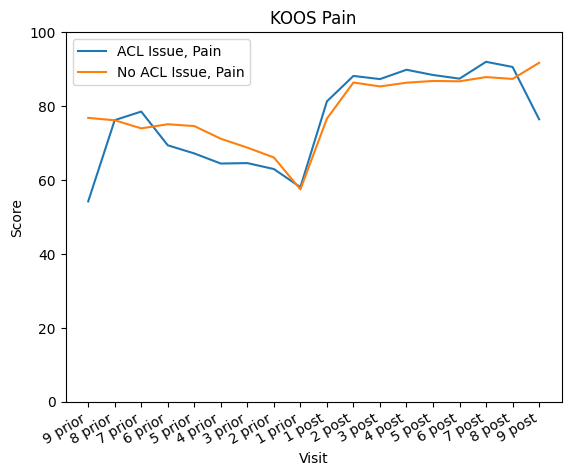

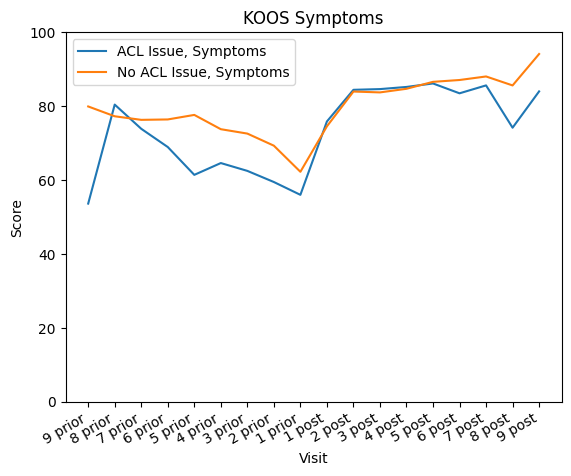

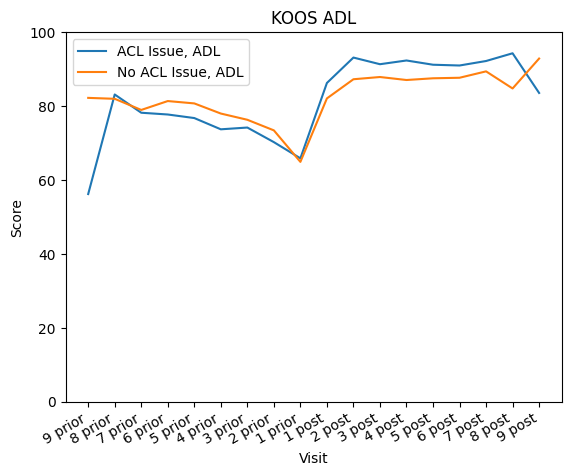

In [478]:
koos_ACL_issue_cols = {'KOOSYMR': 'KOOS Symptoms Right',
                       'KOOSYML': 'KOOS Symptoms Left'
             }

#graph_conditions(koos_ACL_issue_cols,ACL_or_no_IDS,title_list)
graph_conditions_both_knees(koos_lr_subscale_dict,ACL_or_no_IDS,title_list)

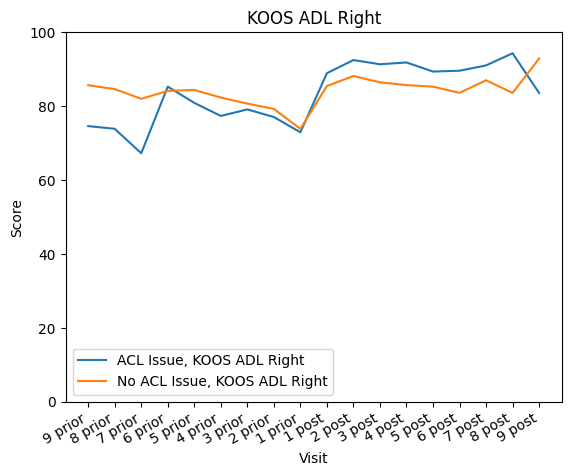

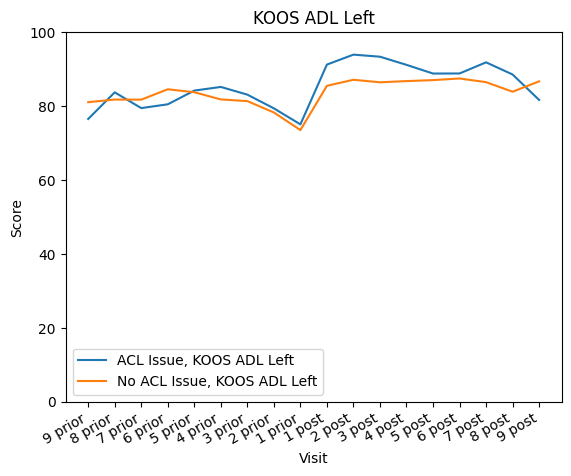

In [479]:
koos_ACL_issue_cols = {'KOOSADLR': 'KOOS ADL Right',
                       'KOOSADLL': 'KOOS ADL Left'
             }


graph_conditions(koos_ACL_issue_cols,ACL_or_no_IDS,title_list)

In [480]:
# fig, ax = plt.subplots()
# ax.plot(dataframe_1['KOOS Pain Left'],label='ACL Problem, Left', color='green')
# ax.plot(dataframe_2['KOOS Pain Left'],label='No ACL Problem Left', color='pink')
# ax.set_autoscale_on(True)
# ax.set_xlabel("Visit")
# ax.legend()
# ax.set_ylabel(ylabel)
# plt.title("KOOS Pain Scores")
# plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# plt.show()

In [481]:
# for i in koos_ACL_issue_cols:
#     print(koos_ACL_issue_cols[i])


In [482]:
koos_r_cols = { 'KOOSYMR': 'KOOS Symptoms'
             }
koos_l_cols = {'KOOSYML': 'KOOS Symptoms'
             }
var_dict=(koos_r_cols, koos_l_cols)
tmp_df = tka_df.loc[tka_df.index.get_level_values(0).isin(ACL_issue_set)]
tka_stats_df = get_stats_df(tmp_df, var_dict[0])
tka_stats_df = tka_stats_df.reindex(index = [(m, v) for m in list(tka_stats_df.index.levels[0]) for v in utils.prior_post_visits ]).dropna()
tka_stats_df_2 = get_stats_df(tmp_df, var_dict[1])
tka_stats_df_2 = tka_stats_df_2.reindex(index = [(m, v) for m in list(tka_stats_df.index.levels[0]) for v in utils.prior_post_visits ]).dropna()


In [7]:
dataframe_1=tka_stats_df.unstack(level=0)['Mean'].reindex(index = utils.prior_post_visits) #ACL Problem
dataframe_2=tka_stats_df_2.unstack(level=0)['Mean'].reindex(index = utils.prior_post_visits) # NO ACL Problem
fig, ax = plt.subplots()
ax.plot(dataframe_1,label='ACL Problem', color='green')
ax.plot(dataframe_2,label='No ACL Problem', color='pink')
ax.set_autoscale_on(True)
ax.set_xlabel("Visit")
ax.set_ylabel(ylabel)
ax.legend()
plt.title("KOOS Symptom Scores")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

NameError: name 'tka_stats_df' is not defined

In [484]:
koos_r_cols = {'KOOSADLR': 'KOOS ADL'
              }
            
koos_l_cols = {'KOOSADLL': 'KOOS ADL'  
              }
var_dict=(koos_r_cols, koos_l_cols)
tmp_df = tka_df.loc[tka_df.index.get_level_values(0).isin(ACL_issue_set)]
tka_stats_df = get_stats_df(tmp_df, var_dict[0])
tka_stats_df = tka_stats_df.reindex(index = [(m, v) for m in list(tka_stats_df.index.levels[0]) for v in utils.prior_post_visits ]).dropna()
tka_stats_df_2 = get_stats_df(tmp_df, var_dict[1])
tka_stats_df_2 = tka_stats_df_2.reindex(index = [(m, v) for m in list(tka_stats_df.index.levels[0]) for v in utils.prior_post_visits ]).dropna()


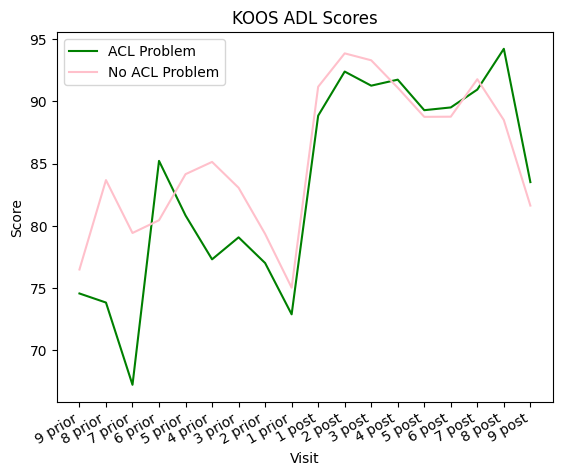

In [485]:
dataframe_1=tka_stats_df.unstack(level=0)['Mean'].reindex(index = utils.prior_post_visits) #ACL Problem
dataframe_2=tka_stats_df_2.unstack(level=0)['Mean'].reindex(index = utils.prior_post_visits) # NO ACL Problem
fig, ax = plt.subplots()
ax.plot(dataframe_1,label='ACL Problem', color='green')
ax.plot(dataframe_2,label='No ACL Problem', color='pink')
ax.set_autoscale_on(True)
ax.set_xlabel("Visit")
ax.set_ylabel(ylabel)
ax.legend()
plt.title("KOOS ADL Scores")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [40]:
MSYIC_severe=set(moaks_df[moaks_df['MSYIC'] == '3: Severe'].index.get_level_values('ID').unique().values)
MEFFWK_severe=set(moaks_df[moaks_df['MEFFWK'] == '3: Severe'].index.get_level_values('ID').unique().values)

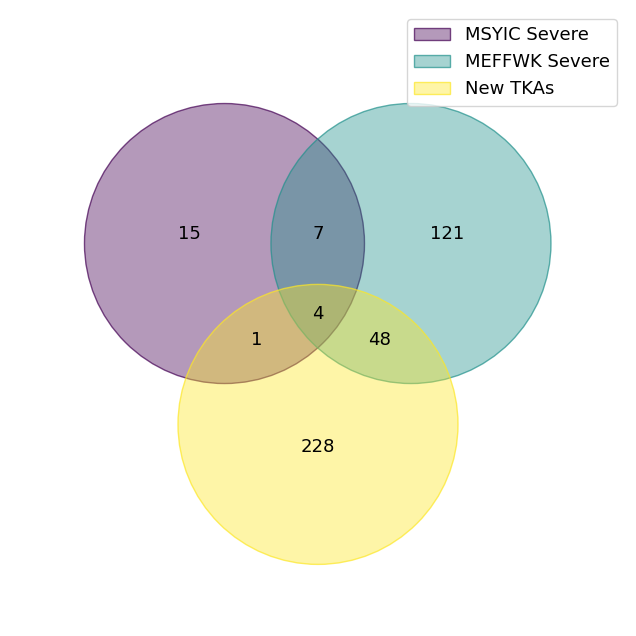

In [41]:
patients = {
    #'All': set(allclinical_df.index.get_level_values('ID')),
    'MSYIC Severe': MSYIC_severe,
    'MEFFWK Severe': MEFFWK_severe,
    'New TKAs': tka_ids
}
plot = venn(patients)
#plot.get_figure().savefig("TKA_venn.svg")

## INFLAMMATORY PHENOTYPE

In [42]:
inflammatory_phenotype_moaks=set(moaks_df.query('MSYIC=="3: Severe" & (MEFFWK=="3: Severe" | MSYIC=="2: Moderate") | MEFFWK=="3: Severe" & (MSYIC=="3: Severe" | MSYIC=="2: Moderate")').index.get_level_values('ID').unique().values)

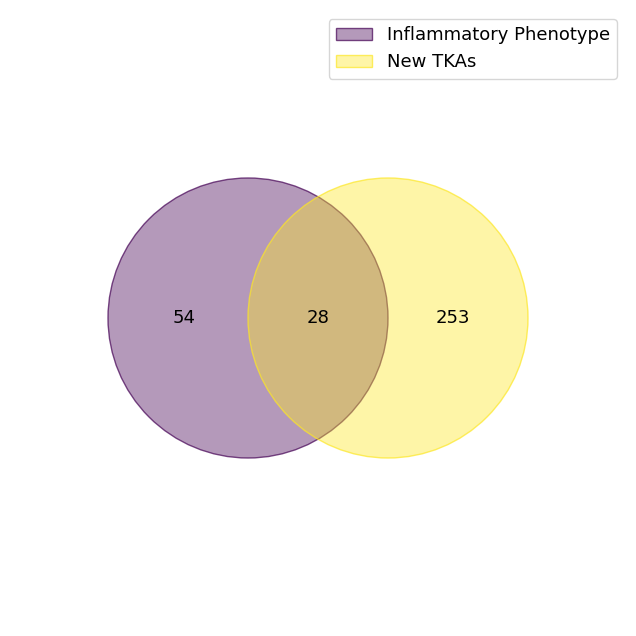

In [43]:
patients = {
    #'All': set(allclinical_df.index.get_level_values('ID')),
    'Inflammatory Phenotype': inflammatory_phenotype_moaks,
    'New TKAs': tka_ids
}
plot = venn(patients)

In [44]:
Inflammatory_Phenotype= (inflammatory_phenotype_moaks ) & tka_ids
Not_Inflammatory_Phenotype= tka_ids - Inflammatory_Phenotype
len(Inflammatory_Phenotype) #28 
len(Not_Inflammatory_Phenotype) # 253
Inflamm_or_No_Set= (Inflammatory_Phenotype,Not_Inflammatory_Phenotype)

koos_r_cols = {'KOOSKPR': 'KOOS Pain',
             'KOOSYMR': 'KOOS Symptoms',
             'KOOSADLR': 'KOOS ADL'
             }
koos_l_cols = {'KOOSKPL': 'KOOS Pain',
             'KOOSYML': 'KOOS Symptoms',
             'KOOSADLL': 'KOOS ADL'  
             }

koos_lr_subscale_dict = {'Pain': ['KOOSKPR', 'KOOSKPL'],
               'Symptoms': ['KOOSYMR', 'KOOSYML'],
                'ADL': ['KOOSADLR', 'KOOSADLL']
              }

In [45]:
tka_koos_tka_df = create_dfs_graphs((koos_r_cols,koos_r_cols), 'KOOS Scores ', 'Inflamm Set, Right', 'No Inflamm Set, Right','Score', 'KOOS_',ylim=[0, 100], lr_subsets=Inflamm_or_No_Set)


TypeError: 'DataFrame' object is not callable

In [46]:
tka_koos_tka_df = create_dfs_graphs((koos_l_cols,koos_l_cols), 'KOOS Scores ', 'Inflammatory Phenotype, Left', 'Not In Inflammatory Phenotype, Left','Score', 'KOOS_',ylim=[0, 100], lr_subsets=Inflamm_or_No_Set)

TypeError: 'DataFrame' object is not callable

In [47]:
koos_ADL_cols = {'KOOSADLR': 'KOOS ADL Right',
                       'KOOSADLL': 'KOOS ADL Left'
             }

koos_pain__cols = {'KOOSKPR': 'KOOS Pain Right',
             'KOOSKPL': 'KOOS Pain Left',
             }
koos_symptoms_cols = {'KOOSYMR': 'KOOS Symptoms Right',
             'KOOSYML': 'KOOS Symptoms Left',
             }

title1= 'Inflammatory Phenotype'
title2= 'Not Inflammatory Phenotype'
title_list=[title1,title2]

#graph_conditions(koos_symptoms_cols,Inflamm_or_No_Set,title_list)
graph_conditions_both_knees(koos_lr_subscale_dict,Inflamm_or_No_Set,title_list)

TypeError: 'DataFrame' object is not callable

In [48]:
graph_conditions(koos_pain__cols,Inflamm_or_No_Set,title_list)

TypeError: 'DataFrame' object is not callable

In [49]:
graph_conditions(koos_ADL_cols,Inflamm_or_No_Set,title_list)

TypeError: 'DataFrame' object is not callable

## CARTILAGE MENISCUS PHENOTYPE 

### First, throw away knees with posterior meniscal root tears (MMRTL or MMRTM) = "1:Yes" 

In [50]:
#MMT_filter_col = [col for col in moaks_df if col.startswith('MMT')]
print(moaks_df['MCMTLA'].unique())

['0: Normal', '.: Missing Form/Incomplete Workbook', '2.2: 10-75% area, 10-75% full thickness', '2: 10-75% area, no full thickness', '3.3: >75% area, >75% full thickness', ..., '1: 1-10% area, no full thickness', '2.1: 10-75% area, 1-10% full thickness', '0.5: Worsening (within grade)', '.M: Missing', '3: >75% area, no full thickness']
Length: 11
Categories (39, object): ['0: Normal', '1: 1-10% area, no full thickness', '1.1: 1-10% area, 1-10% full thickness', '2: 10-75% area, no full thickness', ..., '.W: Impossible value', '.X: Don t Do', '.Y: Unassigned', '.Z: Unassigned']


In [51]:
subset_df = moaks_df[moaks_df["MMRTL"] != "1: Yes"]
subset_df= subset_df[subset_df["MMRTM"] != "1:Yes"]

In [52]:
subset_df=subset_df.loc[:, subset_df.columns.str.startswith('MMT')| subset_df.columns.str.startswith("MCM")]
subset_df

MCMPM  \
ID      Visit SIDE                                             
9000798 V00   LEFT         2: 10-75% area, no full thickness   
9001400 V00   RIGHT  2.2: 10-75% area, 10-75% full thickness   
9001695 V00   RIGHT        2: 10-75% area, no full thickness   
9001897 V00   RIGHT   2.1: 10-75% area, 1-10% full thickness   
              LEFT   2.2: 10-75% area, 10-75% full thickness   
...                                                      ...   
9995338 V06   RIGHT            0.5: Worsening (within grade)   
              LEFT         2: 10-75% area, no full thickness   
9996086 V06   RIGHT                                0: Normal   
9996284 V06   RIGHT        2: 10-75% area, no full thickness   
9996851 V06   RIGHT         1: 1-10% area, no full thickness   

                                                       MCMPL  \
ID      Visit SIDE                                             
9000798 V00   LEFT                                 0: Normal   
9001400 V00   RIGHT        2: 10-75% area, no full thickness   
9001695 V00   RIGHT                                0: Normal   
9001897 V00   RIGHT         1: 1-10% area, no full thickness   
              LEFT         2: 10-75% area, no full thickness   
...                                                      ...   
9995338 V06   RIGHT      3.3: >75% area, >75% full thickness   
              LEFT   2.2: 10-75% area, 10-75% full thickness   
9996086 V06   RIGHT                                0: Normal   
9996284 V06   RIGHT                                0: Normal   
9996851 V06   RIGHT                                0: Normal   

                                                    MCMFMA  \
ID      Visit SIDE                                           
9000798 V00   LEFT       2: 10-75% area, no full thickness   
9001400 V00   RIGHT      2: 10-75% area, no full thickness   
9001695 V00   RIGHT       1: 1-10% area, no full thickness   
9001897 V00   RIGHT       1: 1-10% area, no full thickness   
              LEFT   3.2: >75% area, 10-75% full thickness   
...                                                    ...   
9995338 V06   RIGHT                              0: Normal   
              LEFT                               0: Normal   
9996086 V06   RIGHT                              0: Normal   
9996284 V06   RIGHT                              0: Normal   
9996851 V06   RIGHT                              0: Normal   

                                                      MCMFLA  \
ID      Visit SIDE                                             
9000798 V00   LEFT         2: 10-75% area, no full thickness   
9001400 V00   RIGHT        2: 10-75% area, no full thickness   
9001695 V00   RIGHT                                0: Normal   
9001897 V00   RIGHT                                0: Normal   
              LEFT         2: 10-75% area, no full thickness   
...                                                      ...   
9995338 V06   RIGHT   2.1: 10-75% area, 1-10% full thickness   
              LEFT   2.2: 10-75% area, 10-75% full thickness   
9996086 V06   RIGHT                                0: Normal   
9996284 V06   RIGHT                                0: Normal   
9996851 V06   RIGHT                                0: Normal   

                                                      MCMFMP  \
ID      Visit SIDE                                             
9000798 V00   LEFT   2.2: 10-75% area, 10-75% full thickness   
9001400 V00   RIGHT                                0: Normal   
9001695 V00   RIGHT         1: 1-10% area, no full thickness   
9001897 V00   RIGHT                                0: Normal   
              LEFT                                 0: Normal   
...                                                      ...   
9995338 V06   RIGHT                                0: Normal   
              LEFT   2.2: 10-75% area, 10-75% full thickness   
9996086 V06   RIGHT                                0: Normal   
9996284 V06   RIGHT                          

In [53]:
MMT_subset=subset_df[subset_df.isin(["3: Horizontal tear","6: Partial maceration","8: Complete maceration","2: Radial tear","4: Vertical tear","7: Progressive partial maceration"]).any(axis=1)]

In [54]:
MMT_subset

MCMPM  \
ID      Visit SIDE                                             
9000798 V00   LEFT         2: 10-75% area, no full thickness   
9001695 V00   RIGHT        2: 10-75% area, no full thickness   
9001897 V00   RIGHT   2.1: 10-75% area, 1-10% full thickness   
              LEFT   2.2: 10-75% area, 10-75% full thickness   
              LEFT   2.2: 10-75% area, 10-75% full thickness   
...                                                      ...   
9983798 V06   RIGHT                                0: Normal   
9992358 V06   RIGHT        2: 10-75% area, no full thickness   
9993362 V06   RIGHT                                0: Normal   
9993833 V06   LEFT             0.5: Worsening (within grade)   
9995338 V06   LEFT         2: 10-75% area, no full thickness   

                                                       MCMPL  \
ID      Visit SIDE                                             
9000798 V00   LEFT                                 0: Normal   
9001695 V00   RIGHT                                0: Normal   
9001897 V00   RIGHT         1: 1-10% area, no full thickness   
              LEFT         2: 10-75% area, no full thickness   
              LEFT         2: 10-75% area, no full thickness   
...                                                      ...   
9983798 V06   RIGHT            0.5: Worsening (within grade)   
9992358 V06   RIGHT    3.2: >75% area, 10-75% full thickness   
9993362 V06   RIGHT                                0: Normal   
9993833 V06   LEFT                                 0: Normal   
9995338 V06   LEFT   2.2: 10-75% area, 10-75% full thickness   

                                                      MCMFMA  \
ID      Visit SIDE                                             
9000798 V00   LEFT         2: 10-75% area, no full thickness   
9001695 V00   RIGHT         1: 1-10% area, no full thickness   
9001897 V00   RIGHT         1: 1-10% area, no full thickness   
              LEFT     3.2: >75% area, 10-75% full thickness   
              LEFT     3.2: >75% area, 10-75% full thickness   
...                                                      ...   
9983798 V06   RIGHT                                0: Normal   
9992358 V06   RIGHT        2: 10-75% area, no full thickness   
9993362 V06   RIGHT                                0: Normal   
9993833 V06   LEFT   2.2: 10-75% area, 10-75% full thickness   
9995338 V06   LEFT                                 0: Normal   

                                                      MCMFLA  \
ID      Visit SIDE                                             
9000798 V00   LEFT         2: 10-75% area, no full thickness   
9001695 V00   RIGHT                                0: Normal   
9001897 V00   RIGHT                                0: Normal   
              LEFT         2: 10-75% area, no full thickness   
              LEFT         2: 10-75% area, no full thickness   
...                                                      ...   
9983798 V06   RIGHT        2: 10-75% area, no full thickness   
9992358 V06   RIGHT  2.2: 10-75% area, 10-75% full thickness   
9993362 V06   RIGHT                                0: Normal   
9993833 V06   LEFT   2.2: 10-75% area, 10-75% full thickness   
9995338 V06   LEFT   2.2: 10-75% area, 10-75% full thickness   

                                                      MCMFMP  \
ID      Visit SIDE                                             
9000798 V00   LEFT   2.2: 10-75% area, 10-75% full thickness   
9001695 V00   RIGHT         1: 1-10% area, no full thickness   
9001897 V00   RIGHT                                0: Normal   
              LEFT                                 0: Normal   
              LEFT                                 0: Normal   
...                                                      ...   
9983798 V06   RIGHT                                0: Normal   
9992358 V06   RIGHT        2: 10-75% area, no full thickness   
9993362 V06   RIGHT                                0: Normal   
9993833 V06   LEFT 

## TODO:: In addition, the presence of cartilage damage grades 2.1, 2.2, 3.2, or 3.3, according to MOAKS, in the more severely affected compartment.

In [55]:
cartilage_meniscus_phenotype=set(MMT_subset.index.get_level_values('ID').unique().values)

In [56]:
### In addition, the presence of cartilage damage grades 2.1, 2.2, 3.2, or 3.3, according to MOAKS, in the more severely affected compartment.

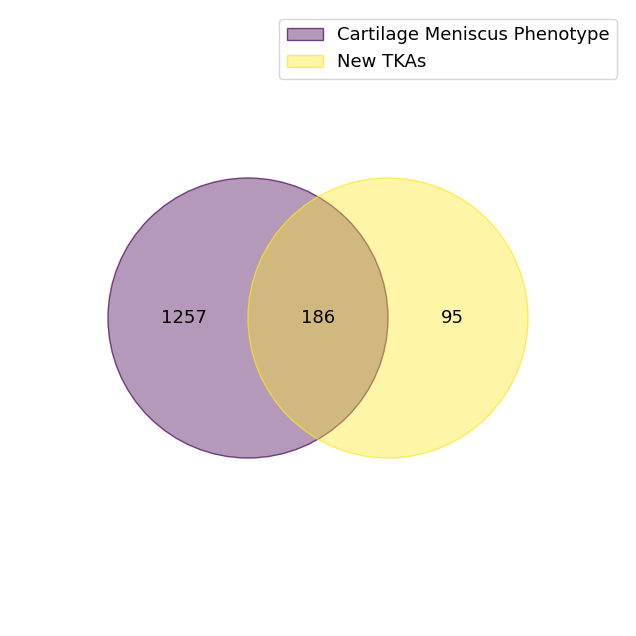

In [57]:
patients_cmp= {
    #'All': set(allclinical_df.index.get_level_values('ID')),
    'Cartilage Meniscus Phenotype': cartilage_meniscus_phenotype,
    'New TKAs': tka_ids
}
plot = venn(patients_cmp)

In [58]:
Cartilage_Meniscus_Phenotype= (cartilage_meniscus_phenotype ) & tka_ids
Not_CM_Phenotype= tka_ids - Cartilage_Meniscus_Phenotype
len(Cartilage_Meniscus_Phenotype) #186
len(Not_CM_Phenotype) # 95
CM_or_no_set= (Cartilage_Meniscus_Phenotype,Not_CM_Phenotype)

koos_r_cols = {'KOOSKPR': 'KOOS Pain',
             'KOOSYMR': 'KOOS Symptoms',
             'KOOSADLR': 'KOOS ADL'
             }
koos_l_cols = {'KOOSKPL': 'KOOS Pain',
             'KOOSYML': 'KOOS Symptoms',
             'KOOSADLL': 'KOOS ADL'  
             }

koos_lr_subscale_dict = {'Pain': ['KOOSKPR', 'KOOSKPL'],
               'Symptoms': ['KOOSYMR', 'KOOSYML'],
                'ADL': ['KOOSADLR', 'KOOSADLL']
              }

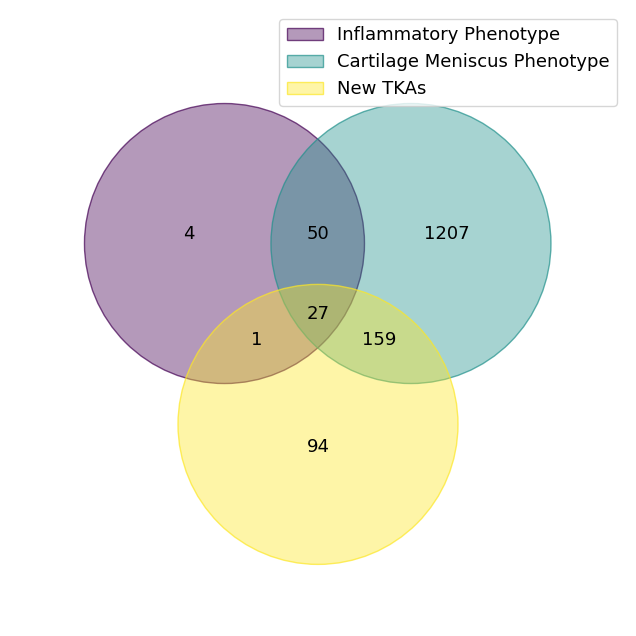

In [59]:
patients_total= {
    'Inflammatory Phenotype': inflammatory_phenotype_moaks,
    'Cartilage Meniscus Phenotype': cartilage_meniscus_phenotype,
    'New TKAs': tka_ids
}
plot = venn(patients_total)

In [60]:
CM_only_Phenotype=Cartilage_Meniscus_Phenotype-Inflammatory_Phenotype # 159 people
#len(Inflammatory_Phenotype) # 28 
Neither_CM_norInflam_Phenotype=tka_ids-CM_only_Phenotype-Inflammatory_Phenotype #94 people 

In [61]:
title1="Inflammatory Phenotype"
title2="Cartilage Meniscus Phenotype"
title3="Neither Phenotype"
title_list=[title1,title2,title3]
Phenotype_Set=(Inflammatory_Phenotype,CM_only_Phenotype,Neither_CM_norInflam_Phenotype)
#graph_conditions(koos_pain__cols,Phenotype_Set,title_list)
graph_conditions_both_knees(koos_lr_subscale_dict,Phenotype_Set,title_list)


TypeError: 'DataFrame' object is not callable

## Atrophic Phenotype

In [62]:
# MOS_filter_col = [col for col in moaks_df if col.startswith('MOS')]
# MOS_filter_col
print(moaks_df['MOSPL'].unique())

['.: Missing Form/Incomplete Workbook', '0: None', '1: Mild', '3: Severe', '2: Moderate']
Categories (34, object): ['1: Mild', '2: Moderate', '3: Severe', '88: Don t know', ..., '.W: Impossible value', '.X: Don t Do', '.Y: Unassigned', '.Z: Unassigned']


In [63]:
print(moaks_df['MCMTLA'].unique())


['0: Normal', '.: Missing Form/Incomplete Workbook', '2.2: 10-75% area, 10-75% full thickness', '2: 10-75% area, no full thickness', '3.3: >75% area, >75% full thickness', ..., '1: 1-10% area, no full thickness', '2.1: 10-75% area, 1-10% full thickness', '0.5: Worsening (within grade)', '.M: Missing', '3: >75% area, no full thickness']
Length: 11
Categories (39, object): ['0: Normal', '1: 1-10% area, no full thickness', '1.1: 1-10% area, 1-10% full thickness', '2: 10-75% area, no full thickness', ..., '.W: Impossible value', '.X: Don t Do', '.Y: Unassigned', '.Z: Unassigned']


In [64]:
MOS_subset=moaks_df.loc[:, moaks_df.columns.str.startswith('MOS') |moaks_df.columns.str.startswith('MCM') ]
MOS_subset=MOS_subset.drop(columns=['MCMPL','MCMPM']) #don't care about patella for this phenotype

## Throw out any knees with MOAKS osteophyte >1 (2 severe, 3 moderate)

In [65]:
boolean=MOS_subset.isin(['2: Moderate','3: Severe'])
boolean=~boolean 
MOS_subset=MOS_subset[boolean.any(axis=1)]

## Only keep knees with at least a grade 2.2 cartilage lesion in at least one of both TFJ compartments

In [66]:
boolean=MOS_subset.isin(['2.2: 10-75% area, 10-75% full thickness','3.3: >75% area, >75% full thickness','3: >75% area, no full thickness'])
MOS_subset=MOS_subset[boolean.any(axis=1)]

In [80]:
atrophic_phenotype=set(MOS_subset.index.get_level_values('ID').unique().values)

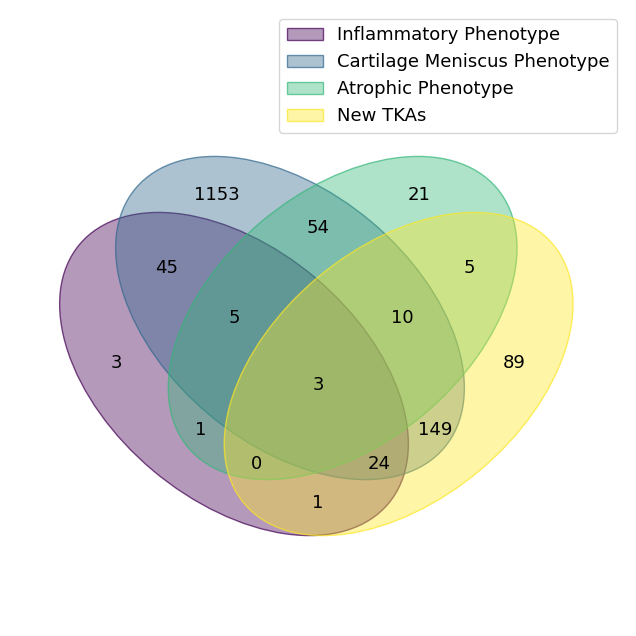

In [81]:
patients_total= {
    'Inflammatory Phenotype': inflammatory_phenotype_moaks,
    'Cartilage Meniscus Phenotype': cartilage_meniscus_phenotype,
    'Atrophic Phenotype':atrophic_phenotype, 
    'New TKAs': tka_ids
}
plot = venn(patients_total)

In [82]:
MBMS_subset=moaks_df.loc[:, moaks_df.columns.str.startswith('MBMS')]

In [83]:
subchondral_bone_phenotype=MBMS_subset[MBMS_subset.isin(["3: > 66% of region"]).any(axis=1)]
#set(MBMS_subset[MBMS_subset.isin(["3: > 66% of region"]).any(axis=1)].index.get_level_values('ID').unique().values)

In [84]:
subchondral_bone_phenotype= subchondral_bone_phenotype[((subchondral_bone_phenotype == ("2: 33%-66% of region")) | (subchondral_bone_phenotype == ("3: > 66% of region"))).sum(axis=1) >= 3]

In [85]:
subchondral_bone_phenotype=set(subchondral_bone_phenotype.index.get_level_values('ID').unique().values)

In [86]:
len(subchondral_bone_phenotype)
Subchondral_Bone_Phenotype= (subchondral_bone_phenotype ) & tka_ids

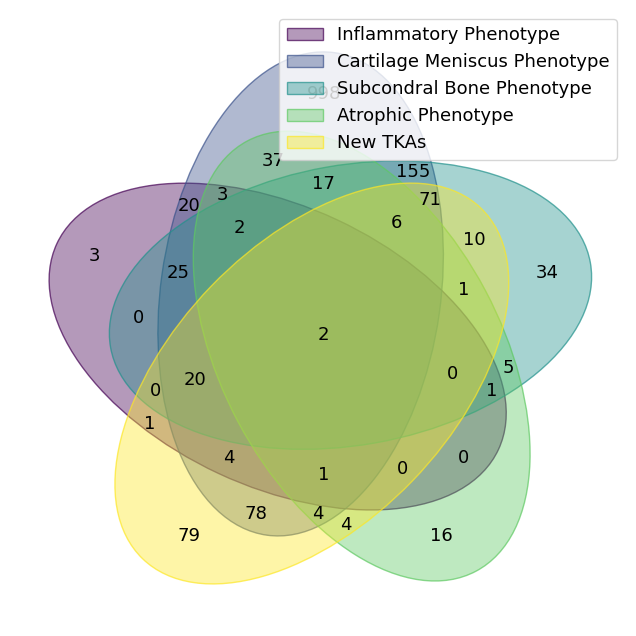

In [87]:
patients_total= {
    'Inflammatory Phenotype': inflammatory_phenotype_moaks,
    'Cartilage Meniscus Phenotype': cartilage_meniscus_phenotype,
    'Subcondral Bone Phenotype': subchondral_bone_phenotype,
    'Atrophic Phenotype':atrophic_phenotype,
    'New TKAs': tka_ids
}
plot = venn(patients_total)

## Hypertrophic Phenotype

In [88]:
MOS_subset=moaks_df.loc[:, moaks_df.columns.str.startswith('MOS') |moaks_df.columns.str.startswith('MCM') ]
MOS_subset=MOS_subset.drop(columns=['MCMPL','MCMPM']) #don't care about patella for this phenotype

### Keep knees with osteophyte score of 3 in any location in TFJ

In [89]:
boolean=MOS_subset.isin(['3: Severe'])
MOS_subset=MOS_subset[boolean.any(axis=1)]

### TODO: For every column, find the spot where it was 3:severe and then check the corresponding cartilage column

In [90]:
hypertrophic_phenotype=set(MOS_subset.index.get_level_values('ID').unique().values)

In [78]:
hy_and_a=Atrophic_Phenotype &H ypertrophic_Phenotype

NameError: name 'Atrophic_Phenotype' is not defined

In [79]:
#moaks_df.index.get_level_values('ID') # 9066155 
#moaks_df.loc(9066155)
hy_and_a_one=moaks_df[moaks_df.index.get_level_values('ID')==9066155]

In [559]:
hy_and_a_one


VERSION READPRJ                                   MCMPM  \
ID      Visit SIDE                                                            
9066155 V00   RIGHT     0.2      22       2: 10-75% area, no full thickness   
              RIGHT     0.2      30  2.1: 10-75% area, 1-10% full thickness   
              LEFT      0.2      65       2: 10-75% area, no full thickness   
        V01   RIGHT     1.2      22       2: 10-75% area, no full thickness   
              LEFT      1.2      65       2: 10-75% area, no full thickness   
        V03   RIGHT     3.2      22       2: 10-75% area, no full thickness   
              LEFT      3.2      65       2: 10-75% area, no full thickness   

                         MCMPL                             MCMFMA     MCMFLA  \
ID      Visit SIDE                                                             
9066155 V00   RIGHT  0: Normal  2: 10-75% area, no full thickness  0: Normal   
              RIGHT  0: Normal   1: 1-10% area, no full thickness  0: Normal   
              LEFT   0: Normal  2: 10-75% area, no full thickness  0: Normal   
        V01   RIGHT  0: Normal  2: 10-75% area, no full thickness  0: Normal   
              LEFT   0: Normal  2: 10-75% area, no full thickness  0: Normal   
        V03   RIGHT  0: Normal  2: 10-75% area, no full thickness  0: Normal   
              LEFT   0: Normal  2: 10-75% area, no full thickness  0: Normal   

                                                      MCMFMP  \
ID      Visit SIDE                                             
9066155 V00   RIGHT  2.2: 10-75% area, 10-75% full thickness   
              RIGHT   2.1: 10-75% area, 1-10% full thickness   
              LEFT                                 0: Normal   
        V01   RIGHT  2.2: 10-75% area, 10-75% full thickness   
              LEFT                                 0: Normal   
        V03   RIGHT  2.2: 10-75% area, 10-75% full thickness   
              LEFT                                 0: Normal   

                                               MCMFLP  \
ID      Visit SIDE                                      
9066155 V00   RIGHT                         0: Normal   
              RIGHT  1: 1-10% area, no full thickness   
              LEFT                          0: Normal   
        V01   RIGHT                         0: Normal   
              LEFT                          0: Normal   
        V03   RIGHT                         0: Normal   
              LEFT                          0: Normal   

                                                      MCMFMC  \
ID      Visit SIDE                                             
9066155 V00   RIGHT  2.2: 10-75% area, 10-75% full thickness   
              RIGHT  2.2: 10-75% area, 10-75% full thickness   
              LEFT                                 0: Normal   
        V01   RIGHT  2.2: 10-75% area, 10-75% full thickness   
              LEFT          1: 1-10% area, no full thickness   
        V03   RIGHT            0.5: Worsening (within grade)   
              LEFT          1: 1-10% area, no full thickness   

                                               MCMFLC  ...  \
ID      Visit SIDE                                     ...   
9066155 V00   RIGHT                         0: Normal  ...   
              RIGHT  1: 1-10% area, no full thickness  ...   
              LEFT                          0: Normal  ...   
        V01   RIGHT                         0: Normal  ...   
              LEFT                          0: Normal  ...   
        V03   RIGHT                         0: Normal  ...   
              LEFT                          0: Normal  ...   

                                                  MGCOTH  \
ID      Visit SIDE                                         
9066155 V00   RIGHT                                0: No   
              RIGHT  .: Missing Form/Incomplete Workbook   
              LEFT   .: Missing Form/Incomplete Workbook   
        V01   RIGHT                                0: No   


## TODO: AND cartilage damage of not more than a grade 1.1 in the same medial and lateral compartment fulfilled the definition.

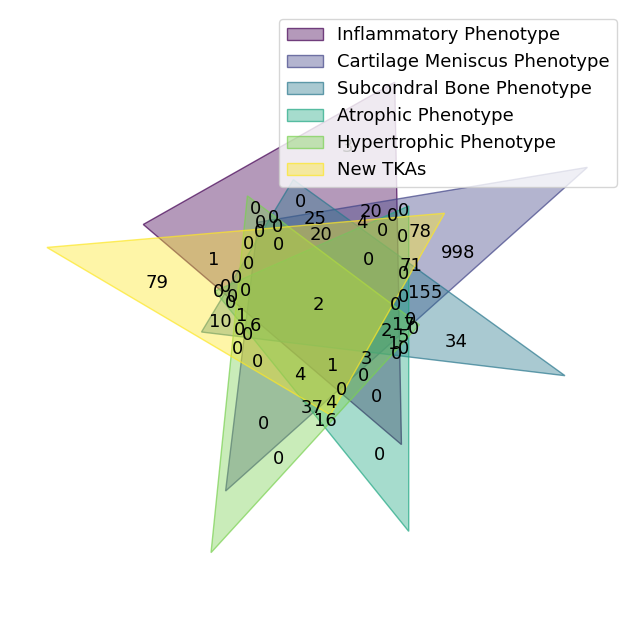

In [91]:
patients_total= {
    'Inflammatory Phenotype': inflammatory_phenotype_moaks,
    'Cartilage Meniscus Phenotype': cartilage_meniscus_phenotype,
    'Subcondral Bone Phenotype': subchondral_bone_phenotype,
    'Atrophic Phenotype':atrophic_phenotype,
    'Hypertrophic Phenotype': hypertrophic_phenotype,
    'New TKAs': tka_ids
}
plot = venn(patients_total)

In [92]:
Atrophic_Phenotype= (atrophic_phenotype ) & tka_ids
Hypertrophic_Phenotype= hypertrophic_phenotype & tka_ids

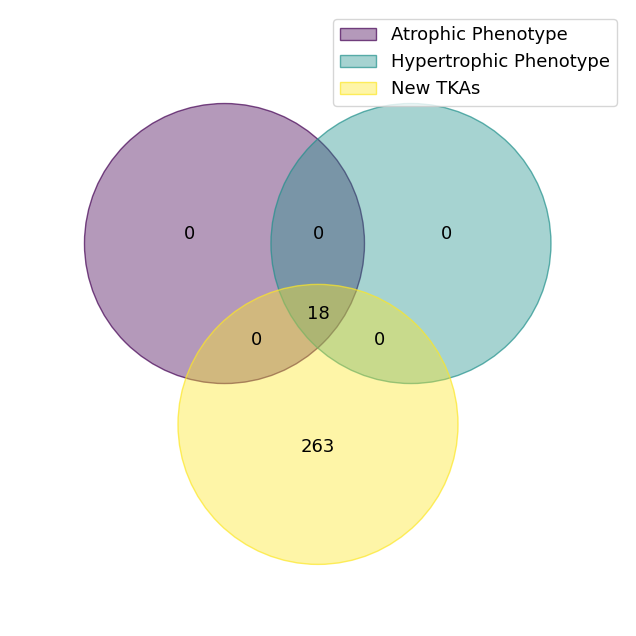

In [93]:

patients= {
    'Atrophic Phenotype':Atrophic_Phenotype,
    'Hypertrophic Phenotype': Hypertrophic_Phenotype,
    'New TKAs': tka_ids
}
plot = venn(patients)

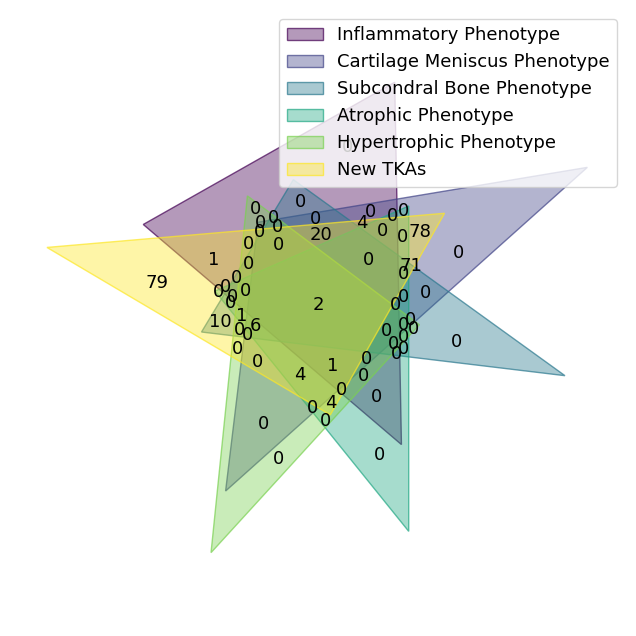

In [94]:

patients= {
    'Inflammatory Phenotype': Inflammatory_Phenotype,
    'Cartilage Meniscus Phenotype': Cartilage_Meniscus_Phenotype,
    'Subcondral Bone Phenotype': Subchondral_Bone_Phenotype,
    'Atrophic Phenotype':Atrophic_Phenotype,
    'Hypertrophic Phenotype': Hypertrophic_Phenotype,
    'New TKAs': tka_ids
}
plot = venn(patients)

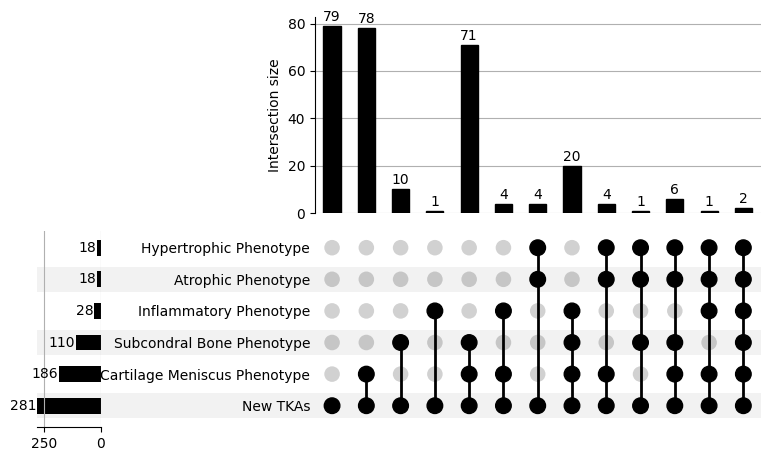

In [95]:
#patients_total
plot = UpSet(from_contents(patients), show_counts=True).plot()
plt.savefig("OAI_upset_graph.svg")

####### TODO: how is it possible for someone to be in hypertrophic and atrophicp phenotype? check this

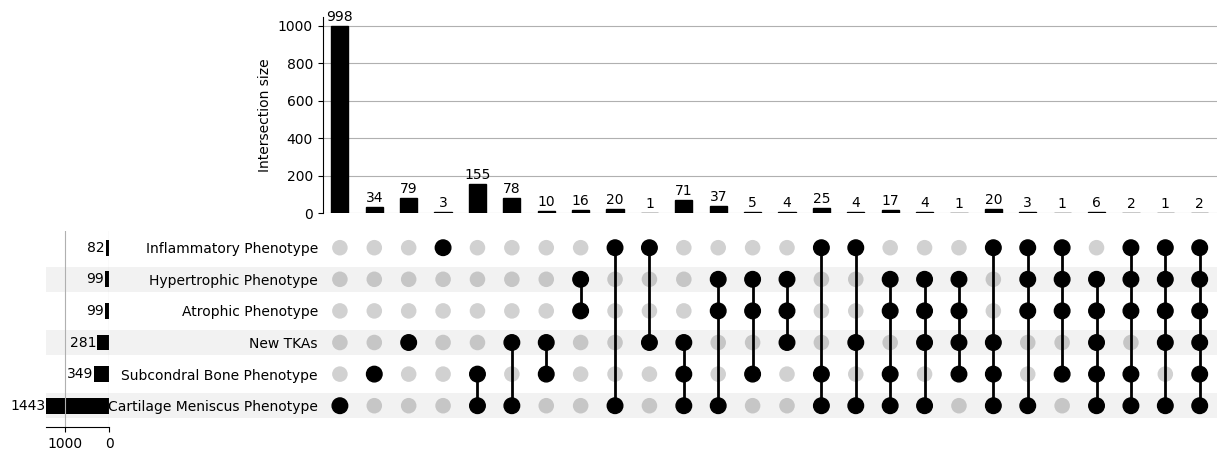

In [96]:
#patients_total
plot = UpSet(from_contents(patients_total), show_counts=True).plot()
plt.savefig("OAI_upset_graph.svg")

In [112]:
## This is too complicated. Let's just take the length of all and then subtract the smallest from the rest

AutoML_dataframe['inflam'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Inflammatory_Phenotype else 0)
AutoML_dataframe['cm'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Cartilage_Meniscus_Phenotype else 0)
AutoML_dataframe['subc'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Subchondral_Bone_Phenotype else 0)
AutoML_dataframe['atroph'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Atrophic_Phenotype else 0)
AutoML_dataframe['hypertrop'] = AutoML_dataframe['id'].apply(lambda x: 1 if x in Hypertrophic_Phenotype else 0)
AutoML_dataframe
AutoML_dataframe.drop(columns=['id'])
AutoML_dataframe.to_csv('AutoML_dataframe.csv',index=True)

In [113]:
AutoML_dataframe

,id,pain,inflam,cm,subc,atroph,hypertrop
9005132,9005132,31.25,0,1,1,0,0
9011918,9011918,22.222221,0,1,0,0,0
9014883,9014883,11.111115,0,1,0,0,0
9015363,9015363,55.555557,0,1,1,0,0
9027422,9027422,19.44445,0,1,0,0,0
...,...,...,...,...,...,...,...
9976720,9976720,44.444443,0,1,0,0,0
9988891,9988891,44.444443,0,1,1,0,0
9991313,9991313,33.333336,0,1,1,0,0
9992318,9992318,25.0,0,0,0,0,0


In [526]:
Atrophic_Phenotype= (atrophic_phenotype ) & tka_ids
Hypertrophic_Phenotype= hypertrophic_phenotype & tka_ids

In [536]:
#len(Atrophic_Phenotype) # 189
#len(Hypertrophic_Phenotype) # 18 
# len(Inflammatory_Phenotype) # 28 
# len(Subchondral_Bone_Phenotype) #110 
# len(Cartilage_Meniscus_Phenotype) # 186
len(None_of_Above_Phenotype) #68

# Inflammatory_Phenotype= Inflammatory_Phenotype-Hypertrophic_Phenotype
# Subchondral_Bone_Phenotype= Subchondral_Bone_Phenotype-Inflammatory_Phenotype-Hypertrophic_Phenotype
# Cartilage_Meniscus_Phenotype= Cartilage_Meniscus_Phenotype- Subchondral_Bone_Phenotype- Inflammatory_Phenotype-Hypertrophic_Phenotype
# Atrophic_Phenotype=Atrophic_Phenotype-Cartilage_Meniscus_Phenotype- Subchondral_Bone_Phenotype- Inflammatory_Phenotype-Hypertrophic_Phenotype

68

In [455]:
#len(Atrophic_Phenotype) # 11
# len(Hypertrophic_Phenotype) # 18
#len(Inflammatory_Phenotype) # 25
len(Subchondral_Bone_Phenotype) # 81
#len(Cartilage_Meniscus_Phenotype) # 78

81

In [222]:
# CM_only_Phenotype=Cartilage_Meniscus_Phenotype-Inflammatory_Phenotype-Subchondral_Bone_Phenotype # 100 people
# Subchondral_Bone_Phenotype= Subchondral_Bone_Phenotype-Inflammatory_Phenotype  #67 people 
# #len(Inflammatory_Phenotype) # 28 
# None_of_Above_Phenotype=tka_ids-CM_only_Phenotype-Inflammatory_Phenotype-Subchondral_Bone_Phenotype #86 people 

In [533]:
None_of_Above_Phenotype= tka_ids-Atrophic_Phenotype-Hypertrophic_Phenotype-Inflammatory_Phenotype-Subchondral_Bone_Phenotype-Cartilage_Meniscus_Phenotype
len(None_of_Above_Phenotype) #68

68

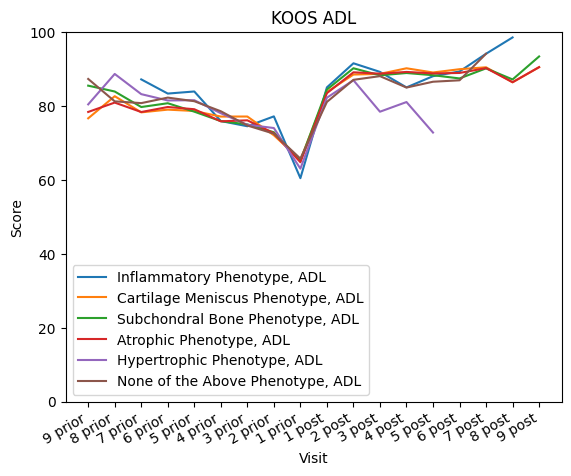

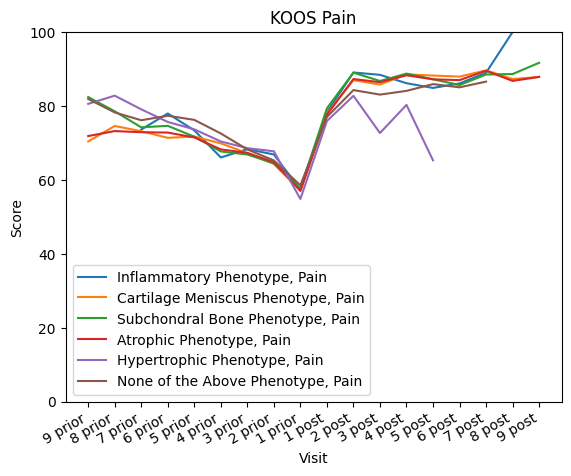

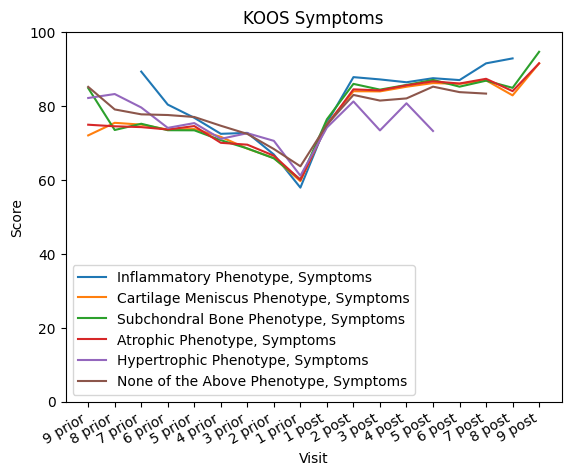

In [534]:
title1="Inflammatory Phenotype"
title2="Cartilage Meniscus Phenotype"
title3="Subchondral Bone Phenotype"
title4="Atrophic Phenotype"
title5="Hypertrophic Phenotype"
title6="None of the Above Phenotype"


title_list=[title1,title2,title3,title4,title5,title6]
Phenotype_Set=(Inflammatory_Phenotype,CM_only_Phenotype,Subchondral_Bone_Phenotype,Atrophic_Phenotype,Hypertrophic_Phenotype,None_of_Above_Phenotype)
#graph_conditions(koos_ADL_cols,Phenotype_Set,title_list)
graph_conditions_both_knees(koos_lr_subscale_dict,Phenotype_Set,title_list)

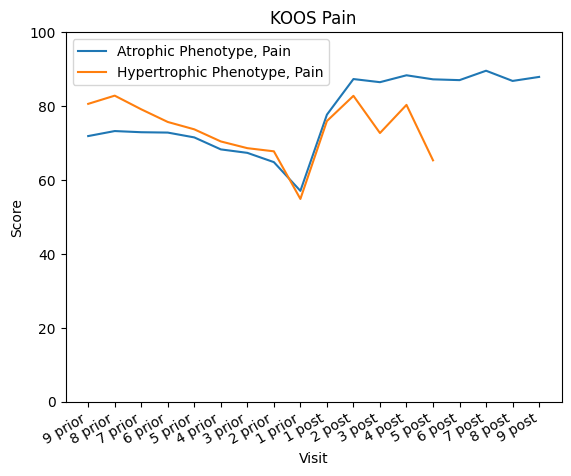

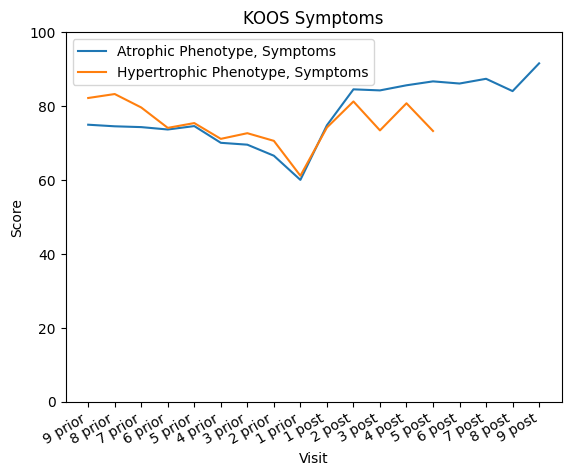

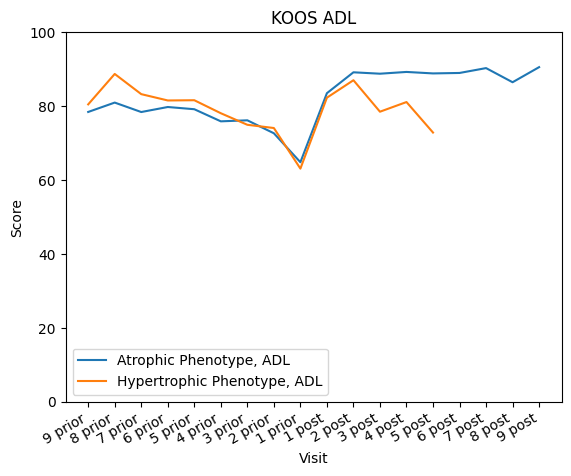

In [535]:

title4="Atrophic Phenotype"
title5="Hypertrophic Phenotype"


title_list=[title4,title5]
Phenotype_Set=(Atrophic_Phenotype,Hypertrophic_Phenotype)
#graph_conditions(koos_ADL_cols,Phenotype_Set,title_list)
graph_conditions_both_knees(koos_lr_subscale_dict,Phenotype_Set,title_list)

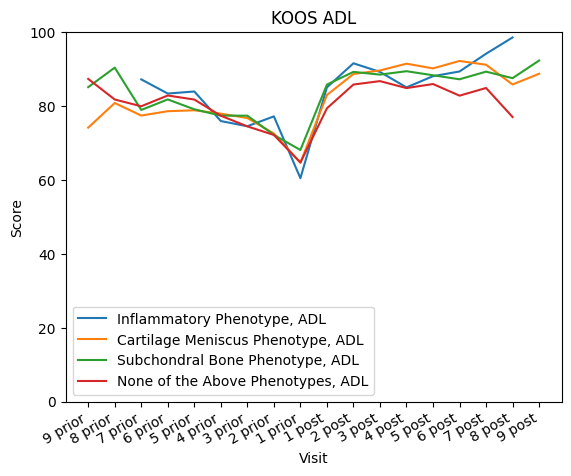

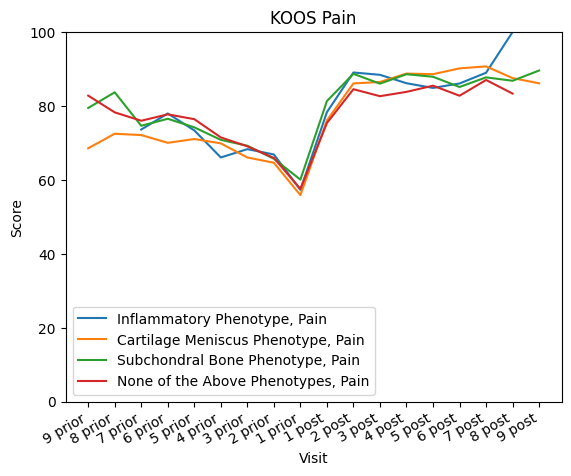

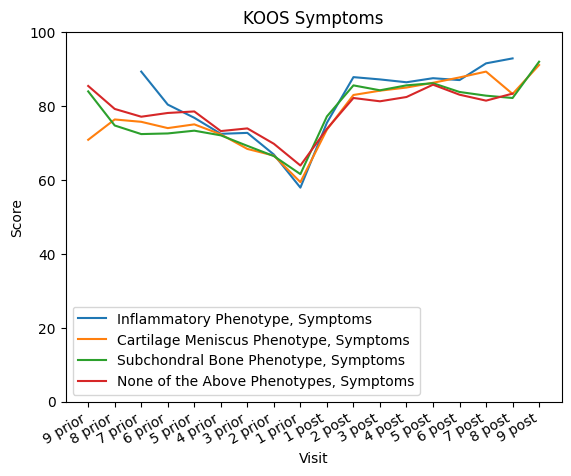

In [345]:
# title1="Inflammatory Phenotype"
# title2="Cartilage Meniscus Phenotype"
# title3="Subchondral Bone Phenotype"
# title4="None of the Above Phenotypes"

# title_list=[title1,title2,title3,title4]
# Phenotype_Set=(Inflammatory_Phenotype,CM_only_Phenotype,Subchondral_Bone_Phenotype,None_of_Above_Phenotype)
# #graph_conditions(koos_ADL_cols,Phenotype_Set,title_list)
# graph_conditions_both_knees(koos_lr_subscale_dict,Phenotype_Set,title_list)

In [359]:
#Find unique values of a column
print(moaks_df['MMRTL'].unique())

['0: No', '1: Yes', '.U: Unable to examine', '.: Missing Form/Incomplete Workbook', '.M: Missing']
Categories (32, object): ['0: No', '1: Yes', '77: Refused', '88: Don t know', ..., '.W: Impossible value', '.X: Don t Do', '.Y: Unassigned', '.Z: Unassigned']


In [27]:
for col in MMT_subset:
  print(MMT_subset[col].unique())

#moaks_df.query('MSYIC=="3: Severe" & MEFFWK=="3: Severe"')

['1: Signal abnormality', '0: Normal', '6: Partial maceration', '3: Horizontal tear', '8: Complete maceration', '.U: Unable to examine', '2: Radial tear', '4: Vertical tear', '.: Missing Form/Incomplete Workbook', '7: Progressive partial maceration']
Categories (36, object): ['0: Normal', '1: Signal abnormality', '2: Radial tear', '3: Horizontal tear', ..., '.W: Impossible value', '.X: Don t Do', '.Y: Unassigned', '.Z: Unassigned']
['6: Partial maceration', '0: Normal', '3: Horizontal tear', '1: Signal abnormality', '4: Vertical tear', ..., '5: Complex tear', '8: Complete maceration', '.U: Unable to examine', '.: Missing Form/Incomplete Workbook', '7: Progressive partial maceration']
Length: 11
Categories (36, object): ['0: Normal', '1: Signal abnormality', '2: Radial tear', '3: Horizontal tear', ..., '.W: Impossible value', '.X: Don t Do', '.Y: Unassigned', '.Z: Unassigned']
['3: Horizontal tear', '1: Signal abnormality', '6: Partial maceration', '5: Complex tear', '0: Normal', ..., '

In [29]:
#Meniscal_Morp_Set=set(moaks_df[moaks_df['MMT'] == '1: Yes'].index.get_level_values('ID').unique().values)
moaks_columns=open('moaks_columns.txt','w')
for (columnName, columnData) in moaks_df.iteritems():
    #print('Column Name : ', columnName)
    moaks_columns.write(str(columnName))
    moaks_columns.write('\n')

moaks_columns.close()

In [68]:
text_file=open('MSYIC.txt','w')
MSYIC_column=moaks_df['MSYIC']
for columnData in MSYIC_column:
    text_file.write(str(columnData))
    text_file.write('\n')
text_file.close()

In [354]:
text_file=open('MMRTL.txt','w')
MSYIC_column=moaks_df['MMRTL']
for columnData in MSYIC_column:
    text_file.write(str(columnData))
    text_file.write('\n')
text_file.close()

In [211]:
text_file=open('MBMSFMA.txt','w')
MSYIC_column=moaks_df['MBMSFMA']
for columnData in MSYIC_column:
    text_file.write(str(columnData))
    text_file.write('\n')
text_file.close()

In [77]:
#MSYIC_df = moaks_df[['ID']]
moaks_df.head()
moaks_df.to_csv('moaks_df.csv')

In [ ]:
## TODO: Separate Into Cohorts Based on Moaks Phenotype first
# Inflammatory phenotype -- MSYIC or MEFFWK
# Cartilage/meniscal phenotype -- MMT** (6) ; MCM** (15) ; MMRTL ; MMRTM 
# Subchondral bone phenotype -- MBMS(** or ***) (15) 
# Atrophic phenotype -- MOS(** or ***) (15) MCM()
